In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd
import seaborn as sns

plt.style.use('fivethirtyeight')
register_matplotlib_converters()

# Find head and tail of data

In [2]:
big_df = pd.read_csv("./input/all_data.csv", index_col=[0], parse_dates=[0]).replace("-", np.nan).astype(float)
big_df["dengue-sg-log"] = np.log(big_df["dengue-sg"] + 1.0)
big_df["population-sg-log"] = np.log(big_df["population-sg"])
data = {}
for colname in big_df.columns:
    n = big_df[colname].shape[0]
    data[colname] = {}
    res_string = colname
    for i in range(n):
        if not pd.isna(big_df[colname][i]):
            res_string += ";{}".format(big_df.index[i])
            data[colname]["start"] = big_df.index[i]
            break
    for i in range(n):
        j = n - 1 - i
        if not pd.isna(big_df[colname][j]):
            res_string += ";{}".format(big_df.index[j])
            data[colname]["end"] = big_df.index[j]
            break
big_df.head()

,dengue-sg,temperature-admiralty-avg,temperature-ang-mo-kio-avg,temperature-boon-lay-east-avg,temperature-changi-avg,temperature-choa-chu-kang-south-avg,temperature-clementi-avg,temperature-east-coast-parkway-avg,temperature-jurong-island-avg,temperature-khatib-avg,...,rainfall-tuas-south-consecutive,rainfall-tuas-west-consecutive,rainfall-ulu-pandan-consecutive,rainfall-upper-peirce-reservoir-consecutive,rainfall-upper-thomson-consecutive,rainfall-whampoa-consecutive,rainfall-yishun-consecutive,population-sg,dengue-sg-log,population-sg-log
human-times,,,,,,,,,,,,,,,,,,,,,
2000-01-08,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027887.0,2.890372,15.208752
2000-01-15,10.0,NaN,NaN,NaN,26.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,2.0,NaN,NaN,4027887.0,2.397895,15.208752
2000-01-22,15.0,NaN,NaN,NaN,26.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,4.0,NaN,NaN,4027887.0,2.772589,15.208752
2000-01-29,15.0,NaN,NaN,NaN,26.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.0,NaN,2.0,NaN,NaN,4027887.0,2.772589,15.208752
2000-02-05,13.0,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,3.0,NaN,NaN,4027887.0,2.639057,15.208752


# Group to regions

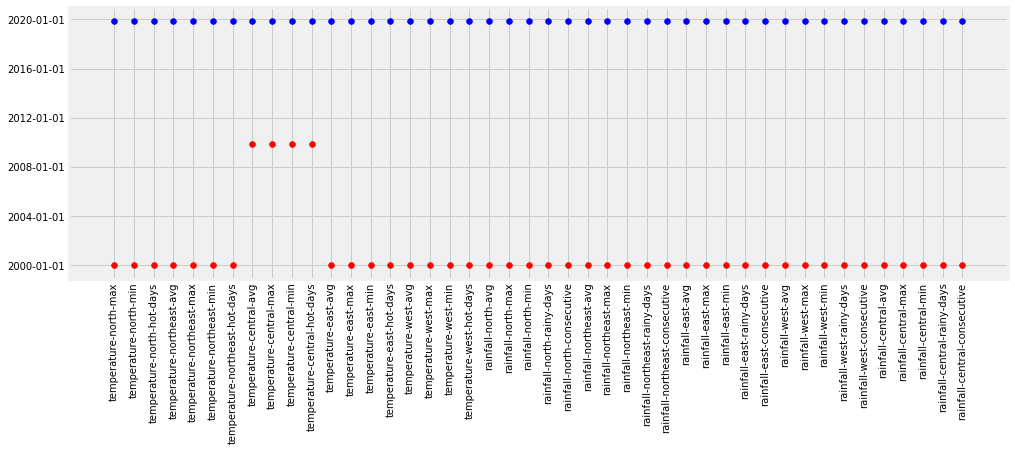

In [3]:
base_regions = {
    "temperature-north": ["admiralty", "khatib", "sembawang"],
    "temperature-northeast": ["ang-mo-kio", "seletar", "tai-seng"],
    "temperature-central": ["marina-barrage", "newton", "sentosa-island"],
    "temperature-east": ["changi", "east-coast-parkway", "pulau-ubin"],
    "temperature-west": ["boon-lay-east", "choa-chu-kang-south", "clementi", "jurong-island", "pasir-panjang", "semakau-island", "tengah", "tuas-south"],
    "rainfall-north": ["admiralty", "admiralty-west", "khatib", "kranji-reservoir", "lim-chu-kang", "mandai", "sembawang", "yishun"],
    "rainfall-northeast": ["ang-mo-kio", "buangkok", "lower-peirce-reservoir", "punggol", "seletar", "serangoon", "serangoon-north", "tai-seng", "upper-peirce-reservoir",
                           "upper-thomson"],
    "rainfall-east": ["chai-chee", "changi", "east-coast-parkway", "pasir-ris-central", "pasir-ris-west", "paya-lebar", "pulau-ubin", "simei", "tanjong-katong"],
    "rainfall-west": ["boon-lay-east", "boon-lay-west", "bukit-panjang", "choa-chu-kang-central", "choa-chu-kang-south", "choa-chu-kang-west", "clementi", "jurong-east",
                      "jurong-north", "jurong-island", "jurong-pier", "kent-ridge", "pasir-panjang", "semakau-island", "tengah", "tuas", "tuas-south", "tuas-west"],
    "rainfall-central": ["botanic-garden", "bukit-timah", "buona-vista", "dhoby-ghaut", "kampong-bahru", "macritchie-reservoir", "marina-barrage", "marine-parade",
                         "newton", "nicoll-highway", "queenstown", "sentosa-island", "somerset-road", "tanjong-pagar", "toa-payoh", "ulu-pandan", "whampoa"]
}
for k in base_regions:
    base_regions[k] = list(map(lambda x: f"{k.split('-')[0]}-{x}", base_regions[k]))

temperature_suffix = ["avg", "max", "min", "hot-days"]
rainfall_suffix = ["avg", "max", "min", "rainy-days", "consecutive"]
regions = {f"{k}-{suffix}": list(map(lambda loc: f"{loc}-{suffix}", base_regions[k]))
           for k in base_regions
           for suffix in (temperature_suffix if "temperature" in k else rainfall_suffix)}

region_head_tail = {}
for k in regions:
    region_head_tail[k] = {}
    region_head_tail[k]["start"] = min(data[loc]["start"] for loc in regions[k])
    region_head_tail[k]["end"] = max(data[loc]["end"] for loc in regions[k])

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
ax.yaxis.set_major_formatter(xfmt)
ax.yaxis_date()
ax.scatter(list(region_head_tail.keys())[1 :], [region_head_tail[k]["start"] for k in region_head_tail][1 :], c="r")
ax.scatter(list(region_head_tail.keys())[1 :], [region_head_tail[k]["end"] for k in region_head_tail][1 :], c="b")

plt.xticks(rotation=90)
plt.show()

# Spatial average

In [4]:
for region in regions:
    # mean(axis=1) accounts for nan and doesn't add count to it
    big_df[region] = big_df[regions[region]].mean(axis=1)
    
for suffix in temperature_suffix:
    big_df[f"temperature-sg-{suffix}"] = big_df[regions[f"temperature-north-{suffix}"] +
                                                regions[f"temperature-northeast-{suffix}"] +
                                                regions[f"temperature-central-{suffix}"] +
                                                regions[f"temperature-east-{suffix}"] +
                                                regions[f"temperature-west-{suffix}"]].mean(axis=1)
for suffix in rainfall_suffix:
    big_df[f"rainfall-sg-{suffix}"] = big_df[regions[f"rainfall-north-{suffix}"] +
                                             regions[f"rainfall-northeast-{suffix}"] +
                                             regions[f"rainfall-central-{suffix}"] +
                                             regions[f"rainfall-east-{suffix}"] +
                                             regions[f"rainfall-west-{suffix}"]].mean(axis=1)

# Interpolate

In [5]:
for suffix in temperature_suffix:
    for colname in ["temperature-north", "temperature-northeast", "temperature-east", "temperature-west"]:
        big_df[f"{colname}-{suffix}"] = big_df[f"{colname}-{suffix}"].interpolate()
for suffix in temperature_suffix:
    big_df[f"temperature-sg-{suffix}"] = big_df[f"temperature-sg-{suffix}"].interpolate()

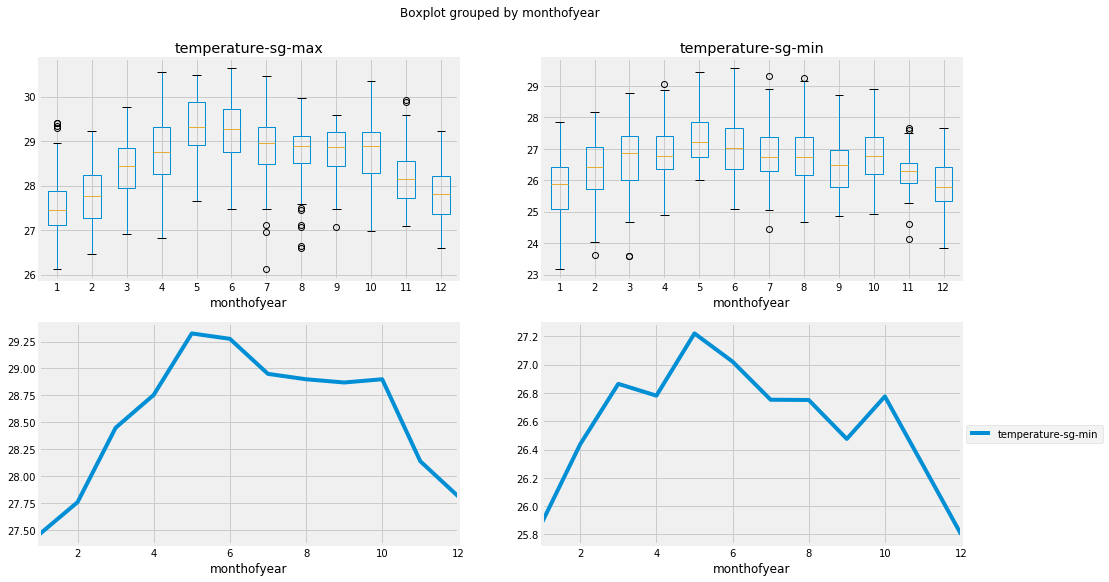

In [6]:
df_max_min = big_df[["temperature-sg-max", "temperature-sg-min"]].copy()
df_max_min["monthofyear"] = df_max_min.index.month

temp_max_median = df_max_min.groupby("monthofyear")["temperature-sg-max"].median()
temp_min_median = df_max_min.groupby("monthofyear")["temperature-sg-min"].median()

f, ax = plt.subplots(2, 2)
f.set_figheight(9)
f.set_figwidth(16)

df_max_min.boxplot("temperature-sg-max", "monthofyear", ax=ax[0][0])
df_max_min.boxplot("temperature-sg-min", "monthofyear", ax=ax[0][1])
temp_max_median.plot(ax=ax[1][0])
temp_min_median.plot(ax=ax[1][1])

plt.legend(loc=7, bbox_to_anchor=(1.35, 0.5))
plt.show()

# Temperature difference from median

In [13]:
df_max_min["temperature-sg-max-diff"] = df_max_min["temperature-sg-max"] - df_max_min["monthofyear"].apply(lambda x: temp_max_median[x])
df_max_min["temperature-sg-min-diff"] = df_max_min["temperature-sg-min"] - df_max_min["monthofyear"].apply(lambda x: temp_min_median[x])
big_df["temperature-sg-max-diff"] = df_max_min["temperature-sg-max-diff"].copy()
big_df["temperature-sg-min-diff"] = df_max_min["temperature-sg-min-diff"].copy()
df_max_min.head()

,temperature-sg-max,temperature-sg-min,monthofyear,temperature-sg-max-diff,temperature-sg-min-diff
human-times,,,,,
2000-01-08,NaN,NaN,1,NaN,NaN
2000-01-15,27.025,24.65,1,-0.437500,-1.236667
2000-01-22,26.825,24.85,1,-0.637500,-1.036667
2000-01-29,26.775,24.65,1,-0.687500,-1.236667
2000-02-05,26.800,25.00,2,-0.959722,-1.437500


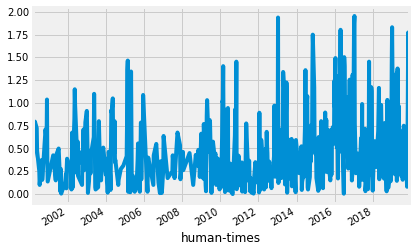

In [8]:
df_max_min["temperature-sg-max-diff"] = df_max_min["temperature-sg-max"] - df_max_min["monthofyear"].apply(lambda x: temp_max_median[x])
df_max_min["temperature-sg-max-diff"][df_max_min["temperature-sg-max-diff"] > 0].plot()

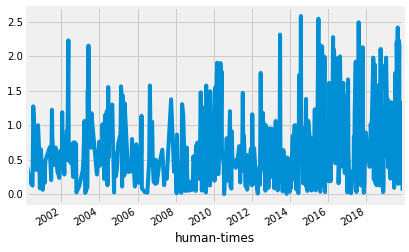

In [9]:
df_max_min["temperature-sg-min-diff"] = df_max_min["temperature-sg-min"] - df_max_min["monthofyear"].apply(lambda x: temp_min_median[x])
df_max_min["temperature-sg-min-diff"][df_max_min["temperature-sg-min-diff"] > 0].plot()

# Compute absolute humidity

In [10]:
humidity_df = pd.read_csv("./input/relative_humidity_monthly_mean.csv", index_col=[0],
                     parse_dates=[0]).replace("-", np.nan).astype(float)
humidity_df.index = humidity_df.index + MonthEnd()
big_df["weekofyear"] = big_df.index.to_series().dt.weekofyear
humidity_df = humidity_df.reindex(pd.date_range(humidity_df.index[0], humidity_df.index[-1],
                                                freq="D")).interpolate()
humidity_df["T2"] = 7.5 * big_df["temperature-sg-avg"] / (237.7 + big_df["temperature-sg-avg"])
humidity_df["Es"] = 6.11 * np.power(10, humidity_df["T2"])
humidity_df["E"] = humidity_df["mean_rh"] * humidity_df["Es"] / 100
humidity_df["Td"] = (-430.22 + 237.7 * np.log(humidity_df["E"])) / (-np.log(humidity_df["E"]) + 19.08)
humidity_df["T1"] = 7.5 * humidity_df["Td"] / (237.7 + humidity_df["Td"])
humidity_df["mean_ah"] = 1000 * (6.11 * np.power(10, humidity_df["T1"]) * 100) / (
    (big_df["temperature-sg-avg"] + 273.16) * 461.5)
humidity_df.reindex(big_df.index).head()

,mean_rh,T2,Es,E,Td,T1,mean_ah
human-times,,,,,,,
2000-01-08,85.712903,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-15,86.074194,0.739477,33.536512,28.866282,23.482853,0.674322,20.906830
2000-01-22,86.435484,0.738836,33.487051,28.944694,23.527940,0.675500,20.965371
2000-01-29,86.796774,0.736271,33.289841,28.894508,23.499095,0.674747,20.936021
2000-02-05,86.831034,0.734345,33.142599,28.778062,23.431999,0.672993,20.856882


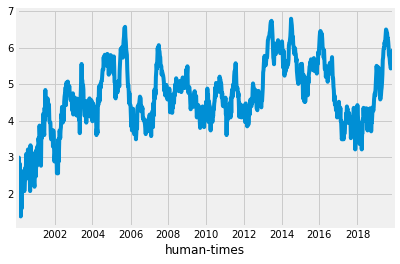

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults

data = big_df["dengue-sg-log"]
data.plot()

C:\LYer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\LYer\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
C:\LYer\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
C:\LYer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.d

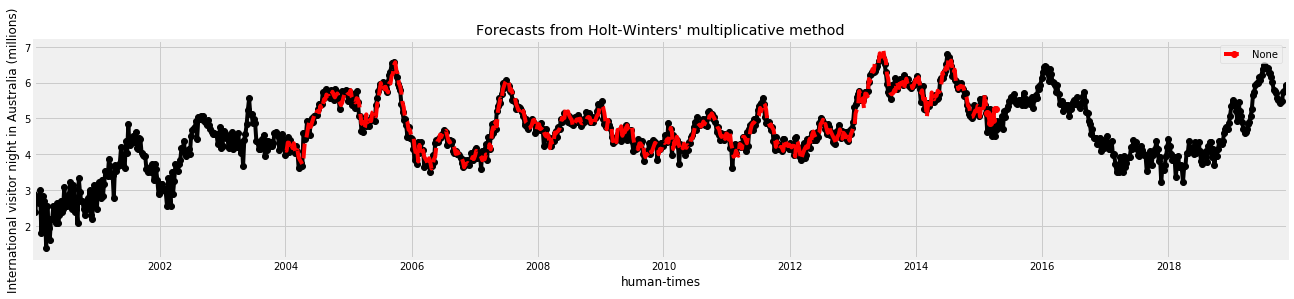

In [43]:
train_years = (data.index > "2004-01-01") & (data.index <= "2015-02-14")
model = ExponentialSmoothing(data.loc[train_years], seasonal_periods=52, trend='add', seasonal='add', freq="7D")
fit1 = model.fit(use_boxcox=True)

ax = data.plot(figsize=(20,4), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')

fit1.forecast(8).plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

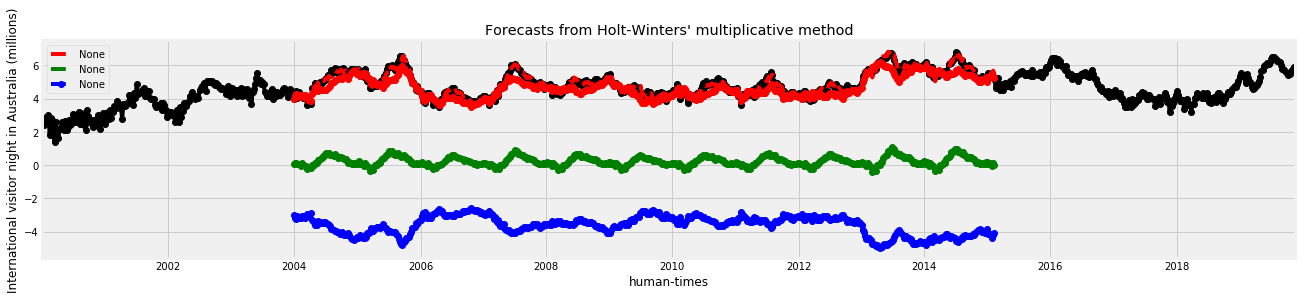

In [44]:
ax = data.plot(figsize=(20,4), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
# fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.level.plot(ax=ax, style='--', marker='o', color='r', legend=True)
fit1.season.plot(ax=ax, style='--', marker='o', color='g', legend=True)
fit1.slope.plot(ax=ax, style='--', marker='o', color='b', legend=True)

plt.show()

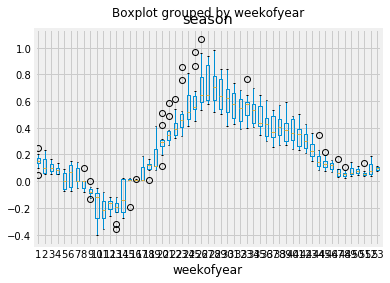

In [45]:
season_df = pd.DataFrame()
season_df["season"] = fit1.season
season_df["weekofyear"] = season_df.index.to_series().dt.weekofyear
bp = season_df.boxplot("season", "weekofyear", return_type="both")

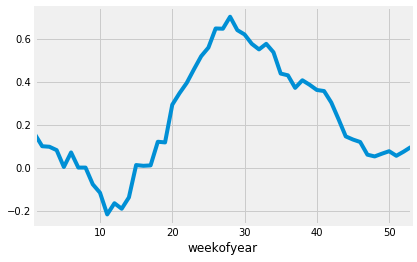

In [47]:
season_median = season_df.groupby("weekofyear")["season"].median()
season_median.plot()
big_df["hw-season-repeat"] = big_df["weekofyear"].apply(lambda x: season_median[x])

# Export to CSV

In [48]:
input_df = big_df[["dengue-sg-log", "population-sg-log",
                   "temperature-sg-avg", "temperature-sg-max", "temperature-sg-min", "temperature-sg-hot-days",
                   "temperature-sg-max-diff", "temperature-sg-min-diff",
                   "rainfall-north-avg", "rainfall-northeast-avg", "rainfall-east-avg", "rainfall-west-avg",
                   "rainfall-central-avg", "rainfall-sg-avg",
                   "rainfall-north-rainy-days", "rainfall-northeast-rainy-days", "rainfall-east-rainy-days",
                   "rainfall-west-rainy-days", "rainfall-central-rainy-days", "rainfall-sg-rainy-days",
                   "rainfall-north-consecutive", "rainfall-northeast-consecutive", "rainfall-east-consecutive",
                   "rainfall-west-consecutive", "rainfall-central-consecutive", "rainfall-sg-consecutive"]].copy()
input_df["rel-humidity-avg"] = humidity_df["mean_rh"]
input_df["abs-humidity-avg"] = humidity_df["mean_ah"]
input_df["hw-season-repeat"] = big_df["hw-season-repeat"]
input_df.to_csv("./output/input_data_hw.csv")